In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns


In [ ]:
# Define transformations for the training set, including normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Define the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:03<00:00, 44920945.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
from tqdm import tqdm
def train_model(model, trainloader, criterion, optimizer, epochs=25):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader, 0)):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.to("cuda"))
            loss = criterion(outputs, labels.to("cuda"))
            loss.backward()
            optimizer.step()

    print('Finished Training')


In [ ]:
def evaluate_model(model, testloader):
    y_pred = []
    y_true = []
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = model(inputs.to("cuda"))
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels.to("cuda")).sum().item()
    accuracy = 100 * correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, f1, y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, classes):
    cf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
# Initialize models
mlp_model = MLP()
encoder_decoder_model = EncoderDecoder()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
encoder_decoder_optimizer = optim.Adam(encoder_decoder_model.parameters(), lr=0.001)

# Train models
print("Training MLP Model")
train_model(mlp_model.to("cuda"), trainloader, criterion, mlp_optimizer)

print("Training Encoder-Decoder Model")
train_model(encoder_decoder_model.to("cuda"), trainloader, criterion, encoder_decoder_optimizer)

# Evaluate models
print("Evaluating MLP Model")
mlp_accuracy, mlp_f1, mlp_y_true, mlp_y_pred = evaluate_model(mlp_model, testloader)
print(f'MLP Test Accuracy: {mlp_accuracy:.2f}%')
print(f'MLP F1 Score: {mlp_f1:.2f}')
plot_confusion_matrix(mlp_y_true, mlp_y_pred, classes)

print("Evaluating Encoder-Decoder Model")
encoder_decoder_accuracy, encoder_decoder_f1, encoder_decoder_y_true, encoder_decoder_y_pred = evaluate_model(encoder_decoder_model, testloader)
print(f'Encoder-Decoder Test Accuracy: {encoder_decoder_accuracy:.2f}%')
print(f'Encoder-Decoder F1 Score: {encoder_decoder_f1:.2f}')
plot_confusion_matrix(encoder_decoder_y_true, encoder_decoder_y_pred, classes)


Training MLP Model


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.avg_pool2 = nn.AvgPool2d((2,2))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool2(x)
        x = self.layer3(x)
        x = self.avg_pool2(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [ ]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_model = MLP().to(device)
encoder_decoder_model = EncoderDecoder().to(device)
lenet_model = LeNet().to(device)
resnet_model = ResNet18().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

lenet_optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
print("Training ResNet Model")
train_model(resnet_model, trainloader, criterion, resnet_optimizer)

print("Training LeNet Model")
train_model(lenet_model, trainloader, criterion, lenet_optimizer)



print("Evaluating LeNet Model")
lenet_accuracy, lenet_f1, lenet_y_true, lenet_y_pred = evaluate_model(lenet_model, testloader)
print(f'LeNet Test Accuracy: {lenet_accuracy:.2f}%')
print(f'LeNet F1 Score: {lenet_f1:.2f}')
plot_confusion_matrix(lenet_y_true, lenet_y_pred, classes)

print("Evaluating ResNet Model")
resnet_accuracy, resnet_f1, resnet_y_true, resnet_y_pred = evaluate_model(resnet_model, testloader)
print(f'ResNet Test Accuracy: {resnet_accuracy:.2f}%')
print(f'ResNet F1 Score: {resnet_f1:.2f}')
plot_confusion_matrix(resnet_y_true, resnet_y_pred, classes)


Evaluating MLP Model
MLP Test Accuracy: 9.30%
MLP F1 Score: 0.04


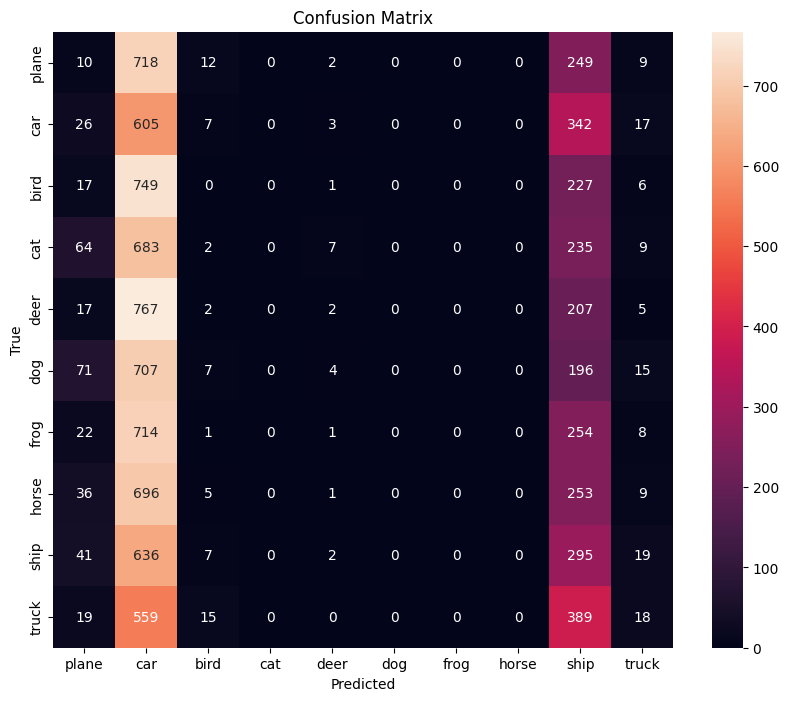

Evaluating Encoder-Decoder Model
Encoder-Decoder Test Accuracy: 10.00%
Encoder-Decoder F1 Score: 0.02


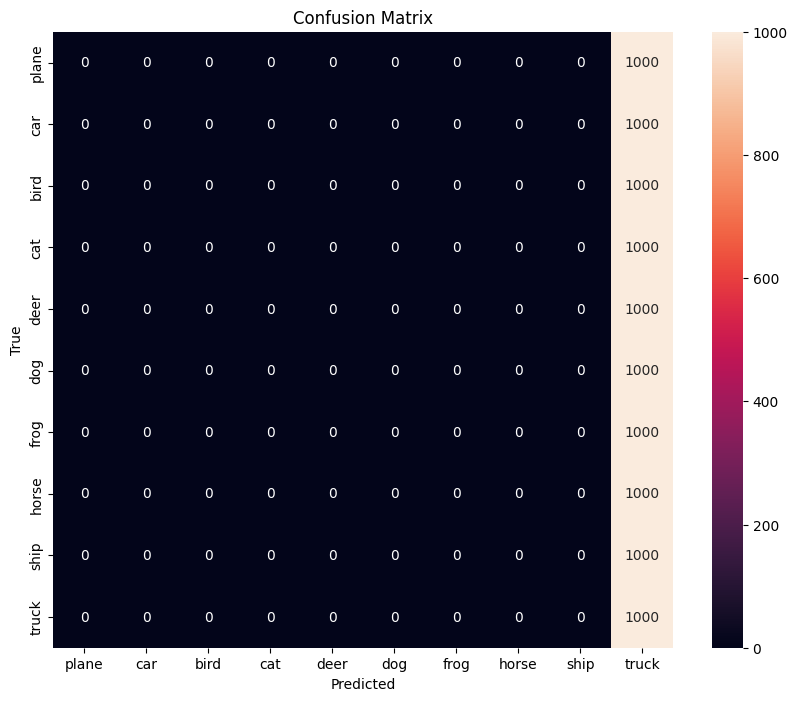

Evaluating LeNet Model
LeNet Test Accuracy: 63.21%
LeNet F1 Score: 0.63


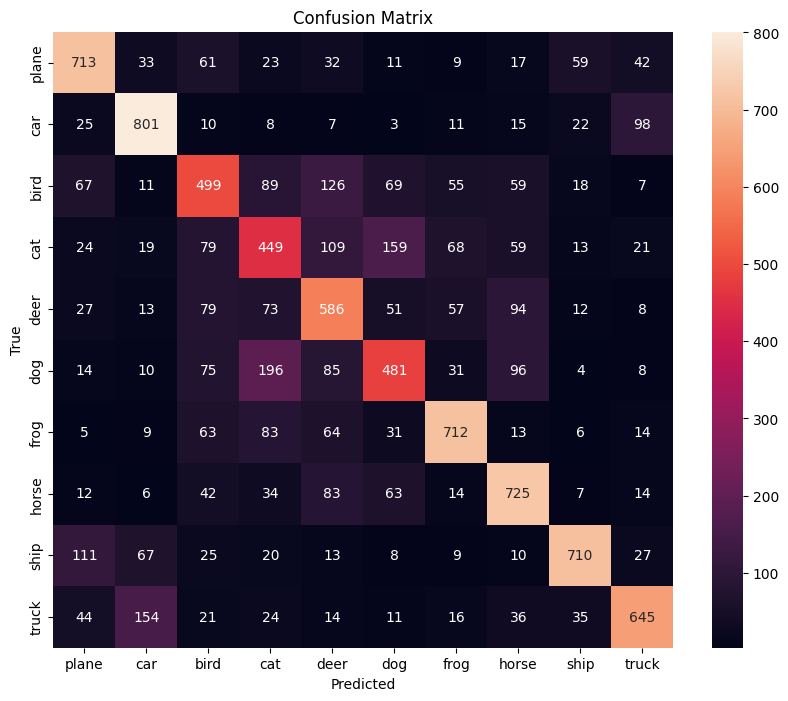

Evaluating ResNet Model
ResNet Test Accuracy: 87.25%
ResNet F1 Score: 0.87


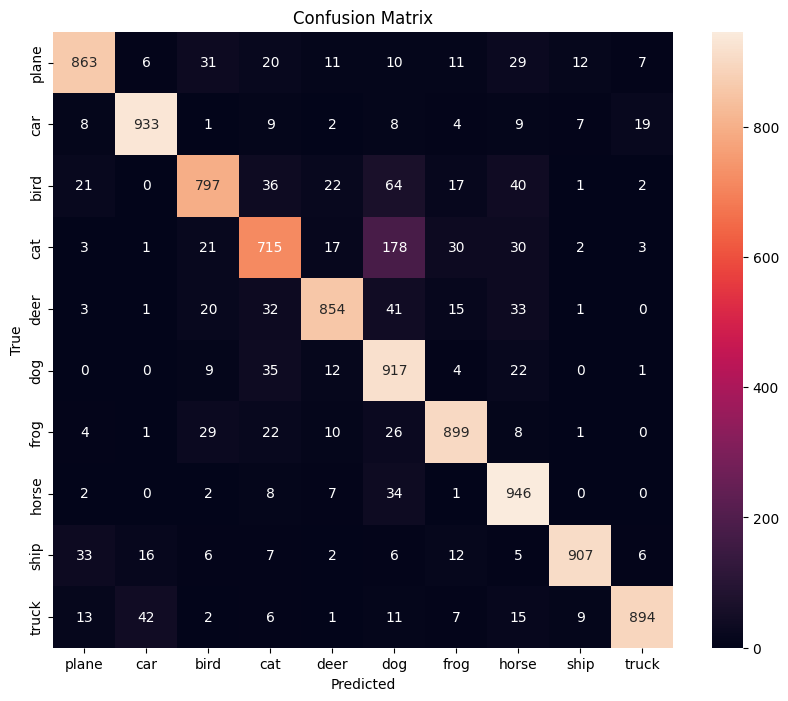

In [ ]:

# Evaluate models
print("Evaluating MLP Model")
mlp_accuracy, mlp_f1, mlp_y_true, mlp_y_pred = evaluate_model(mlp_model, testloader)
print(f'MLP Test Accuracy: {mlp_accuracy:.2f}%')
print(f'MLP F1 Score: {mlp_f1:.2f}')
plot_confusion_matrix(mlp_y_true, mlp_y_pred, classes)

print("Evaluating Encoder-Decoder Model")
encoder_decoder_accuracy, encoder_decoder_f1, encoder_decoder_y_true, encoder_decoder_y_pred = evaluate_model(encoder_decoder_model, testloader)
print(f'Encoder-Decoder Test Accuracy: {encoder_decoder_accuracy:.2f}%')
print(f'Encoder-Decoder F1 Score: {encoder_decoder_f1:.2f}')
plot_confusion_matrix(encoder_decoder_y_true, encoder_decoder_y_pred, classes)



print("Evaluating LeNet Model")
lenet_accuracy, lenet_f1, lenet_y_true, lenet_y_pred = evaluate_model(lenet_model, testloader)
print(f'LeNet Test Accuracy: {lenet_accuracy:.2f}%')
print(f'LeNet F1 Score: {lenet_f1:.2f}')
plot_confusion_matrix(lenet_y_true, lenet_y_pred, classes)

print("Evaluating ResNet Model")
resnet_accuracy, resnet_f1, resnet_y_true, resnet_y_pred = evaluate_model(resnet_model, testloader)
print(f'ResNet Test Accuracy: {resnet_accuracy:.2f}%')
print(f'ResNet F1 Score: {resnet_f1:.2f}')
plot_confusion_matrix(resnet_y_true, resnet_y_pred, classes)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    return accuracy, f1, recall, precision

def plot_metrics_comparison(models_metrics):
    models = list(models_metrics.keys())
    accuracies = [metrics['accuracy'] for metrics in models_metrics.values()]

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')

    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracy Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    fig.tight_layout()
    plt.show()


# Calculate metrics for each model
mlp_metrics = calculate_metrics(mlp_y_true, mlp_y_pred)
encoder_decoder_metrics = calculate_metrics(encoder_decoder_y_true, encoder_decoder_y_pred)
lenet_metrics = calculate_metrics(lenet_y_true, lenet_y_pred)
resnet_metrics = calculate_metrics(resnet_y_true, resnet_y_pred)

# Store metrics in a dictionary for comparison
models_metrics = {
    'MLP': {'accuracy': mlp_metrics[0], 'f1': mlp_metrics[1], 'recall': mlp_metrics[2], 'precision': mlp_metrics[3]},
    'Encoder-Decoder': {'accuracy': encoder_decoder_metrics[0], 'f1': encoder_decoder_metrics[1], 'recall': encoder_decoder_metrics[2], 'precision': encoder_decoder_metrics[3]},
    'LeNet': {'accuracy': lenet_metrics[0], 'f1': lenet_metrics[1], 'recall': lenet_metrics[2], 'precision': lenet_metrics[3]},
    'ResNet': {'accuracy': resnet_metrics[0], 'f1': resnet_metrics[1], 'recall': resnet_metrics[2], 'precision': resnet_metrics[3]}
}

# Plot the comparison
plot_metrics_comparison(models_metrics)

# Print the metrics for each model
for model, metrics in models_metrics.items():
    print(f"{model} Metrics:")
    print(f"  Accuracy: {metrics['accuracy']:.5f}")
    print(f"  F1 Score: {metrics['f1']:.5f}")
    print(f"  Recall: {metrics['recall']:.5f}")
    print(f"  Precision: {metrics['precision']:.5f}")
    print()


NameError: name 'mlp_y_true' is not defined